In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as sg
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
pd.set_option('display.float_format', lambda x: '%.10f' % x)
from sklearn.metrics import r2_score
import datetime as dt 
from sklearn.mixture import GaussianMixture 

%matplotlib inline

In [4]:
path = '/nfshome/skp454/DOE/'

In [67]:
def anomalyDetection(y,pval = 0.2,iterN=20, ncomp = 2):

    if len(y.shape) == 1:
        y = np.array(y).reshape(-1, 1)
    rind = np.array(range(y.shape[0]))
    
    #clustering model
    gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0) 
    for i in range(iterN): #iterate
        print('Iteration {}'.format(i+1))  
        clustering=gm.fit(y[rind,:]) #fit EM clustering model excluding outliers
        l=clustering.score_samples(y) #estimate likelihood for each point
        Lthres=sorted(l)[int(len(l)*pval)] #anomaly threshold
        rind0=0+rind
        rind=l>Lthres #non-anomalous points
        if all(rind==rind0):
            print('Convergence in {} iterations'.format(i+1))
            break
    return l<Lthres

In [99]:
def plotAnomalies(df, value, outlier):
    plt.subplots(figsize = (15,5))
    plt.plot(np.arange(0, len(df)), df[value], label='No. of Outgoing Cabs')
    plt.plot(np.arange(0, len(df)), df[value]*df[outlier], '.', label ='Detected Anomalies')
    plt.ylim(50, max(df[value]+100))
    plt.xlim(0, len(df))
    plt.legend()

### JFK Incoming flights
1. read and concat files
2. aggregate into 3 hrs bucket

In [6]:
# read and concat files
df_jfkMain = pd.DataFrame()
for file in os.listdir(path+'data/'):
    if 'JFK' in file and 'Dest' in file:
        df_jfkTemp =  pd.read_csv(path+'data/'+file)
        df_jfkMain = df_jfkMain.append(df_jfkTemp)

# view data        
print("length Jfk: ", len(df_jfkMain))
df_jfkMain.head()

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


length Jfk:  63959


Year  Quarter  Month  DayofMonth  DayOfWeek FlightDate  \
0  2018        1      3           1          4   2018/3/1   
1  2018        1      3           2          5   2018/3/2   
2  2018        1      3           3          6   2018/3/3   
3  2018        1      3           4          7   2018/3/4   
4  2018        1      3           5          1   2018/3/5   

  Marketing_Airline_Network Operated_or_Branded_Code_Share_Partners  \
0                        AA                            AA_CODESHARE   
1                        AA                            AA_CODESHARE   
2                        AA                            AA_CODESHARE   
3                        AA                            AA_CODESHARE   
4                        AA                            AA_CODESHARE   

   DOT_ID_Marketing_Airline IATA_Code_Marketing_Airline  ...  Div4TailNum  \
0                     19805                          AA  ...          nan   
1                     19805                          AA  ...          nan   
2                     19805                          AA  ...          nan   
3                     19805                          AA  ...          nan   
4                     19805                          AA  ...          nan   

   Div5Airport  Div5AirportID  Div5AirportSeqID  Div5WheelsOn Div5TotalGTime  \
0          nan            nan               nan           nan            nan   
1          nan            nan               nan           nan            nan   
2          nan            nan               nan           nan            nan   
3          nan            nan               nan           nan            nan   
4          nan            nan               nan           nan            nan   

   Div5LongestGTime Div5WheelsOff Div5TailNum  Duplicate  
0               nan           nan         nan          N  
1               nan           nan         nan          N  
2               nan           nan         nan          N  
3               nan           nan         nan          N  
4               nan           nan         nan          N  

[5 rows x 119 columns]

In [7]:
# remove all columns except flight date and arrival time
df_jfkMain = df_jfkMain[['Year','Month','DayofMonth','ArrTime','FlightDate']]

# drop na
df_jfkMain.dropna(inplace=True)

#convert ArrTime to string
df_jfkMain['ArrTime'] = df_jfkMain['ArrTime'].astype(str)

# reset index
df_jfkMain.reset_index(drop = True, inplace = True)

# view data        
print("length Jfk: ", len(df_jfkMain))
df_jfkMain.head()

length Jfk:  61674


Year  Month  DayofMonth ArrTime FlightDate
0  2018      3           1  1520.0   2018/3/1
1  2018      3           3  1541.0   2018/3/3
2  2018      3           4  1509.0   2018/3/4
3  2018      3           5  1717.0   2018/3/5
4  2018      3           6  1527.0   2018/3/6

In [8]:
#extract hour from ArrTime
df_jfkMain['Hour'] = df_jfkMain.apply(lambda x: x['ArrTime'][:-4], axis=1)

#drop unusual
df_jfkMain = df_jfkMain[df_jfkMain['Hour'] != '']

#hour to int
df_jfkMain['Hour'] = df_jfkMain['Hour'].astype(int)
print(df_jfkMain['Hour'].unique())

# view data        
print("length Jfk: ", len(df_jfkMain))
df_jfkMain.head()

[15 17 16 19 18 14 20  7  8 13 21 22 23  5  1  6  2  9 10  3 24 11 12  4]
length Jfk:  59857


Year  Month  DayofMonth ArrTime FlightDate  Hour
0  2018      3           1  1520.0   2018/3/1    15
1  2018      3           3  1541.0   2018/3/3    15
2  2018      3           4  1509.0   2018/3/4    15
3  2018      3           5  1717.0   2018/3/5    17
4  2018      3           6  1527.0   2018/3/6    15

In [9]:
# create time bucket 3 hours and concat with date
def timebucket(row):
    year = str(row['Year'])
    month = str(row['Month'])
    day = str(row['DayofMonth'])
    hour = str(int(np.ceil(row['Hour']/3)))
    if len(day)<2:
        day = '0'+ day
    return year+month+day+hour

In [10]:
# time bucket of each row
df_jfkMain['TimeBucket'] = df_jfkMain.apply(lambda x: timebucket(x), axis = 1)

# len of time bucket
len(df_jfkMain['TimeBucket'].unique())

# sort by time bucket
df_jfkMain = df_jfkMain.sort_values(by = ['TimeBucket'], ascending=True)

# groupby time bucket
df_jfkTS = df_jfkMain.groupby(['TimeBucket'])['DayofMonth'].count()

# reset index
#df_jfkTS.reset_index(drop = True, inplace = True)

Text(0.5, 1.0, 'Time Series for No. of Incoming Flights ')

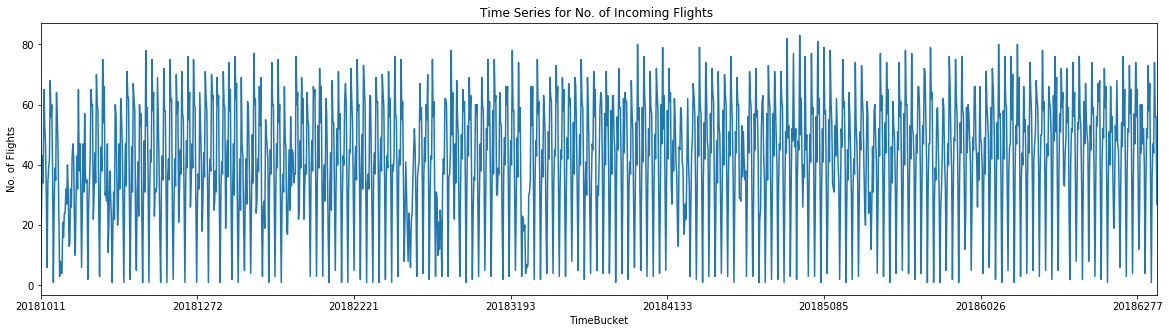

In [11]:
plt.subplots(figsize = (20,5))
df_jfkTS.plot()
plt.ylabel('No. of Flights')
plt.title("Time Series for No. of Incoming Flights ")

### Yellow Cab Outgoing Traffic

In [12]:
# import yellow cab data
df_jfkYellowMain = pd.read_csv(path+'data/'+'yellow_JFK_out_15.csv')

# view data
df_jfkYellowMain.head()

Unnamed: 0  start_time_index  counts  index_of_day  weekday  day
0           0                 0      53             0        0    0
1           1                 1      42             1        0    0
2           2                 2      43             2        0    0
3           3                 3      36             3        0    0
4           4                 4      38             4        0    0

#### Please Note: 
1. The day variable corresponds to day of the year
2. The start_time_index corresponds to 96 fifteen minutes bucket of the day (24hour/15minutes = 96 Buckets)
3. We need to convert these two to time bucket matching that of jfk_flight data.

In [13]:
# convert dy to date
df_jfkYellowMain['Date'] = df_jfkYellowMain.apply(lambda x: pd.to_datetime('1/1/2018') + pd.DateOffset(x['day']), axis =1)

# view data
df_jfkYellowMain.head()

Unnamed: 0  start_time_index  counts  index_of_day  weekday  day       Date
0           0                 0      53             0        0    0 2018-01-01
1           1                 1      42             1        0    0 2018-01-01
2           2                 2      43             2        0    0 2018-01-01
3           3                 3      36             3        0    0 2018-01-01
4           4                 4      38             4        0    0 2018-01-01

In [14]:
# create time bucket 3 hours and concat with date
def timebucket_cab(row):
    year = str(row['Date'].year)
    month = str(row['Date'].month)
    day = str(row['Date'].day)
    hour = str(int(np.ceil((row['index_of_day']+1)/12)))
    if len(day)<2:
        day = '0'+ day
    return year+month+day+hour

In [86]:
# time bucket of each row
df_jfkYellowMain['TimeBucket'] = df_jfkYellowMain.apply(lambda row: timebucket_cab(row), axis = 1)

# sort by time bucket
df_jfkYellowMain = df_jfkYellowMain.sort_values(by = ['TimeBucket'], ascending=True)

# groupby time bucket
df_jfkYellowTS = df_jfkYellowMain.groupby(['TimeBucket'])['counts'].sum()

Text(0.5, 1.0, 'Time Series for No. of Outgoing Cabs')

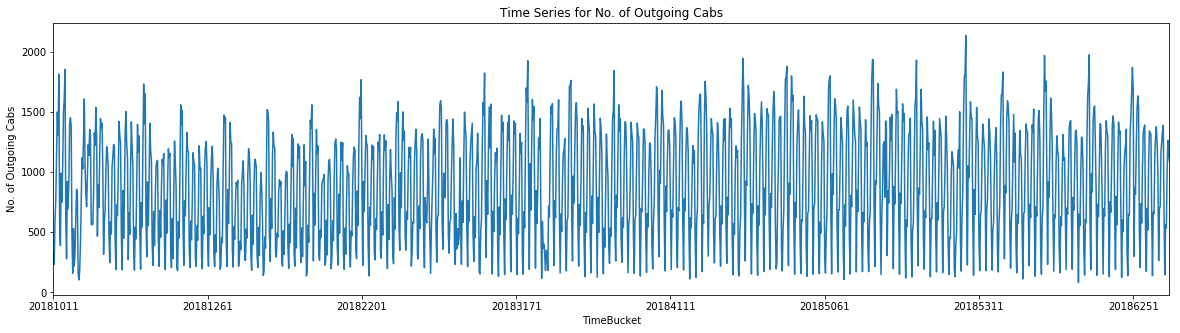

In [87]:
plt.subplots(figsize = (20,5))
df_jfkYellowTS.plot()
plt.ylabel('No. of Outgoing Cabs')
plt.title("Time Series for No. of Outgoing Cabs")

Text(0.5, 0, 'Residual')

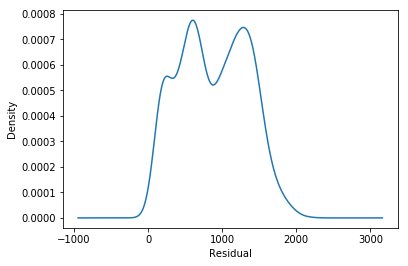

In [88]:
df_jfkYellowTS.plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

In [89]:
anomaly = anomalyDetection(df_jfkYellowTS, ncomp=3)
df_jfkYellowTS = pd.DataFrame(df_jfkYellowTS)
df_jfkYellowTS['Outlier'] = anomaly

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Convergence in 8 iterations


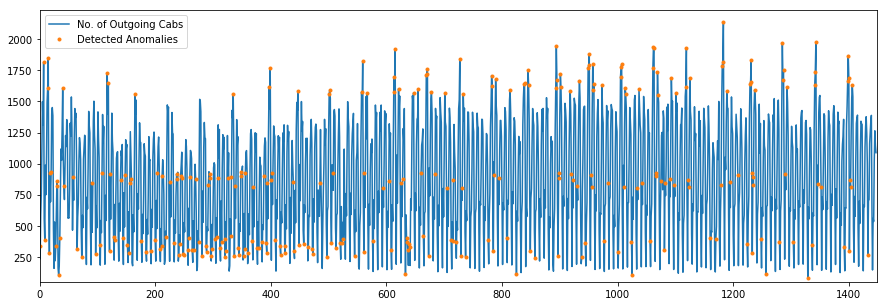

In [96]:
plotAnomalies(df_jfkYellowTS, value='counts', outlier='Outlier')

### Join Flight and Cab Data
1. Join both data
2. Check linear relation between both

In [17]:
# Merge both data
df_jfk = pd.concat([df_jfkTS,df_jfkYellowTS], axis=1)

# fill na
df_jfk.fillna(0, inplace = True)

#change column names
df_jfk.columns = ['nFlights', 'nCabs']

#View data
df_jfk.head()

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


nFlights  nCabs
20181011  8.0000000000    340
20181012 29.0000000000    233
20181013 43.0000000000    591
20181014 34.0000000000    758
20181015 65.0000000000   1136

In [18]:
def daytime(row):
    a = str(row['Timestamp'])
    x = dt.datetime(int(a[0:4]), int(a[4:5]), int(a[5:7]))
    return x.weekday(), a[7:8]

In [19]:
df_jfk['Timestamp'] = df_jfk.index
df_jfk['Day'], df_jfk['Time'] = zip(*df_jfk.apply(lambda x: daytime(x), axis =1))
df_jfk = pd.concat([df_jfk, pd.get_dummies(df_jfk['Day'], prefix='Day')], axis=1)
df_jfk = pd.concat([df_jfk, pd.get_dummies(df_jfk['Time'], prefix='Time')], axis=1)
df_jfk.head()

nFlights  nCabs Timestamp  Day Time  Day_0  Day_1  Day_2  Day_3  \
20181011  8.0000000000    340  20181011    0    1      1      0      0      0   
20181012 29.0000000000    233  20181012    0    2      1      0      0      0   
20181013 43.0000000000    591  20181013    0    3      1      0      0      0   
20181014 34.0000000000    758  20181014    0    4      1      0      0      0   
20181015 65.0000000000   1136  20181015    0    5      1      0      0      0   

          Day_4  Day_5  Day_6  Time_1  Time_2  Time_3  Time_4  Time_5  Time_6  \
20181011      0      0      0       1       0       0       0       0       0   
20181012      0      0      0       0       1       0       0       0       0   
20181013      0      0      0       0       0       1       0       0       0   
20181014      0      0      0       0       0       0       1       0       0   
20181015      0      0      0       0       0       0       0       1       0   

          Time_7  Time_8  
20181011       0       0  
20181012       0       0  
20181013       0       0  
20181014       0       0  
20181015       0       0

Correlation b/w nFlights & nCabs: 0.5223458831056713


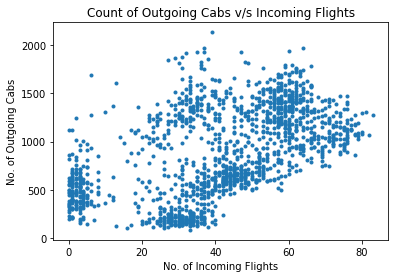

In [20]:
# Plot scatter plot of flights and cab
plt.plot(df_jfk['nFlights'], df_jfk['nCabs'],'.')
plt.xlabel('No. of Incoming Flights')
plt.ylabel('No. of Outgoing Cabs')
plt.title( 'Count of Outgoing Cabs v/s Incoming Flights')
print("Correlation b/w nFlights & nCabs:", np.corrcoef(df_jfk['nFlights'], df_jfk['nCabs'])[0][1])

### Model 1:  Without Intercept

In [21]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights-1', data = df_jfk).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     6381.
Date:                Tue, 18 Jun 2019   Prob (F-statistic):               0.00
Time:                        16:13:14   Log-Likelihood:                -10828.
No. Observations:                1448   AIC:                         2.166e+04
Df Residuals:                    1447   BIC:                         2.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nFlights      19.4956      0.244     79.884      0.0

Text(0, 0.5, 'No.of Cabs')

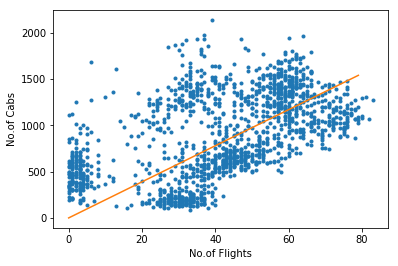

In [22]:
# Scatter plot with best fit line
plt.plot(df_jfk['nFlights'], df_jfk['nCabs'],'.')
plt.plot(np.arange(0,80,1), np.arange(0,80,1) * lm.params['nFlights'], '-')
plt.xlabel('No.of Flights')
plt.ylabel('No.of Cabs')


In [93]:
df_jfk['predCabs'] = lm.params['nFlights'] * df_jfk['nFlights']
df_jfk['resCabs'] = np.log(df_jfk['nCabs']+1) - np.log(df_jfk['predCabs']+1)
mse = mean_squared_error(df_jfk['nCabs'],df_jfk['predCabs'])
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 427.923


Text(0.5, 0, 'Residual')

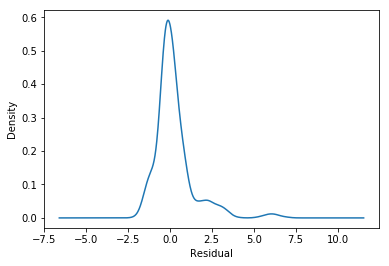

In [94]:
df_jfk['resCabs'].plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Convergence in 5 iterations


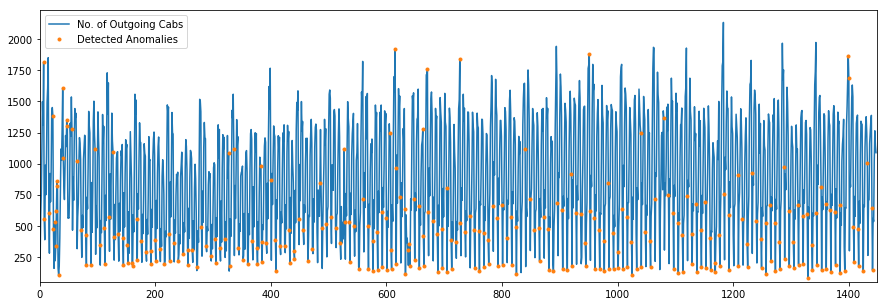

In [100]:
anomaly = anomalyDetection(df_jfk['resCabs'], ncomp=1)
df_jfk['Outlier'] = anomaly
plotAnomalies(df_jfk, value='nCabs', outlier='Outlier')

### Model 2:  With Intercept

In [101]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights', data = df_jfk).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     542.6
Date:                Tue, 18 Jun 2019   Prob (F-statistic):          3.62e-102
Time:                        17:08:02   Log-Likelihood:                -10692.
No. Observations:                1448   AIC:                         2.139e+04
Df Residuals:                    1446   BIC:                         2.140e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    400.8692     23.146     17.319      0.0

Text(0, 0.5, 'No.of Cabs')

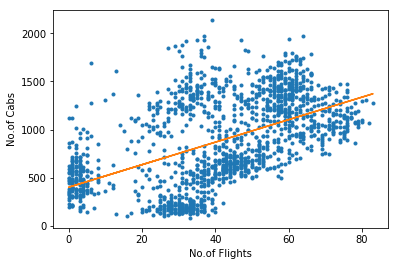

In [102]:
# Scatter plot with best fit line
plt.plot(df_jfk['nFlights'], df_jfk['nCabs'],'.')
plt.plot(df_jfk['nFlights'], lm.predict(), '-')
plt.xlabel('No.of Flights')
plt.ylabel('No.of Cabs')

In [103]:
df_jfk['predCabs'] = lm.predict()
df_jfk['resCabs'] = np.log(df_jfk['nCabs']) - np.log(df_jfk['predCabs'])
mse = mean_squared_error(df_jfk['nCabs'],df_jfk['predCabs'])
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 389.435


Text(0.5, 0, 'Residual')

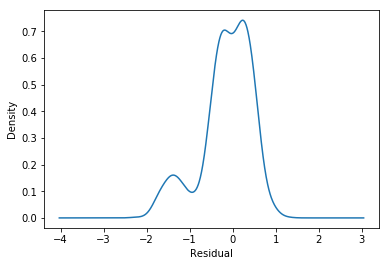

In [104]:
df_jfk['resCabs'].plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

Iteration 1
Iteration 2
Iteration 3
Convergence in 3 iterations


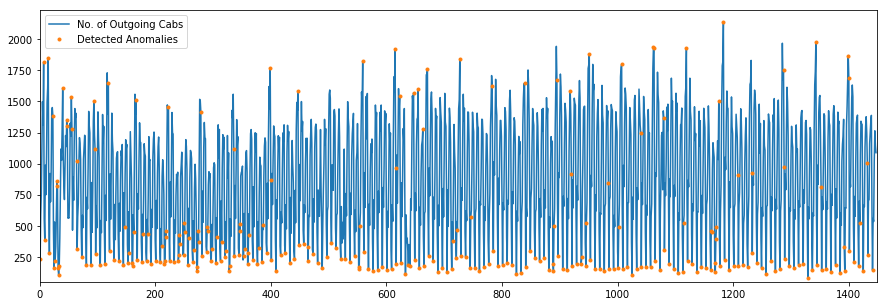

In [105]:
anomaly = anomalyDetection(df_jfk['resCabs'], ncomp=3)
df_jfk['Outlier'] = anomaly
plotAnomalies(df_jfk, value='nCabs', outlier='Outlier')

### Model3: With Time of Day & Day of Week Dummies

In [106]:
'nFlights+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8'

'nFlights+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8'

In [107]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+\
Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8', data = df_jfk).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     616.1
Date:                Tue, 18 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:09:14   Log-Likelihood:                -9511.4
No. Observations:                1448   AIC:                         1.905e+04
Df Residuals:                    1433   BIC:                         1.913e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    428.8447     18.192     23.574      0.0

In [137]:
df_jfk['predCabs'] = lm.predict()
df_jfk['resCabs'] = np.log(df_jfk['nCabs']+1) - np.log(df_jfk['predCabs']+1)
df_jfk.dropna(inplace = True)
mse = mean_squared_error(df_jfk['nCabs'],df_jfk['predCabs'])
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 172.354


/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 0, 'Residual')

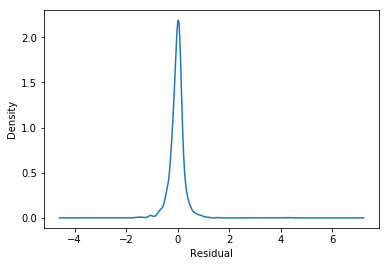

In [138]:
df_jfk['resCabs'].plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Convergence in 5 iterations


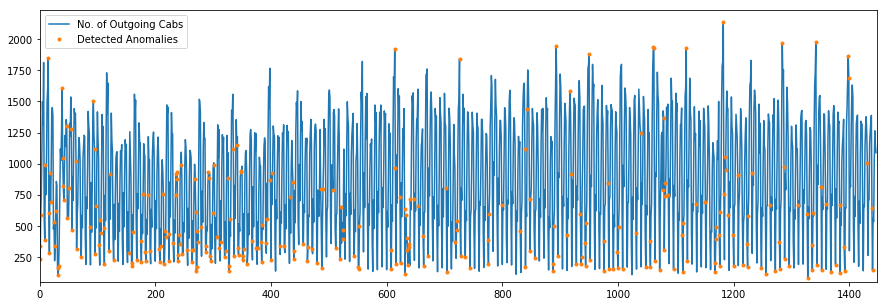

In [139]:
anomaly = anomalyDetection(df_jfk['resCabs'].dropna(), ncomp=1)
df_jfk['Outlier'] = anomaly
plotAnomalies(df_jfk.dropna(), value='nCabs', outlier='Outlier')

## ARIMA MODELLING

### Cab Time Series

In [111]:
# Series = df_jfk['nCabs']
# Series = np.array(Series.iloc[8:]) - np.array(Series.iloc[:-8])

In [112]:
# plt.figure(figsize=(20, 5))
# plt.plot(Series)

In [140]:
# check for stationarity
# result = adfuller(Series)
result = adfuller(df_jfk['nCabs'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.050682
p-value: 0.000018
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


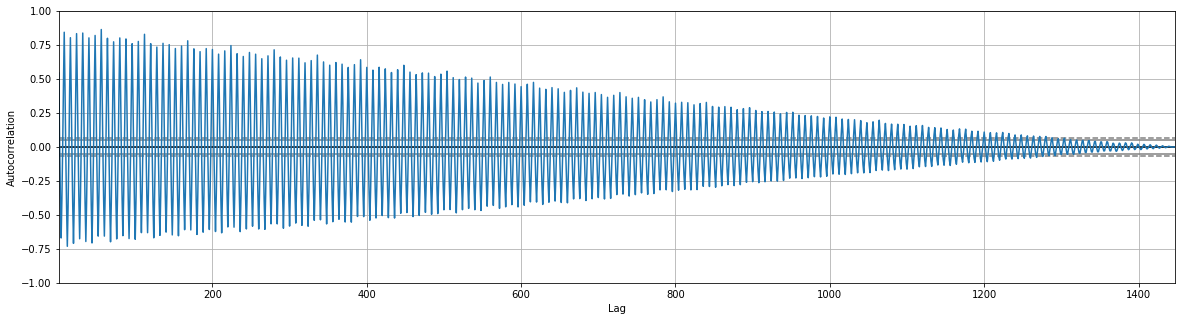

In [141]:
# plot autocorrelation in the data
plt.figure(figsize=(20, 5))
# ax = autocorrelation_plot(Series)
ax = autocorrelation_plot(df_jfk['nCabs'])


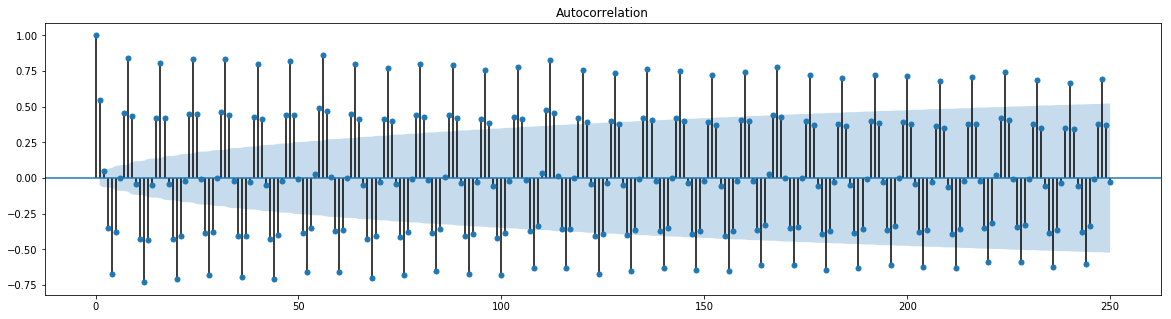

In [142]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_acf(Series, ax=ax, lags=250)
sg.plot_acf(df_jfk['nCabs'], ax=ax, lags=250)
plt.show()

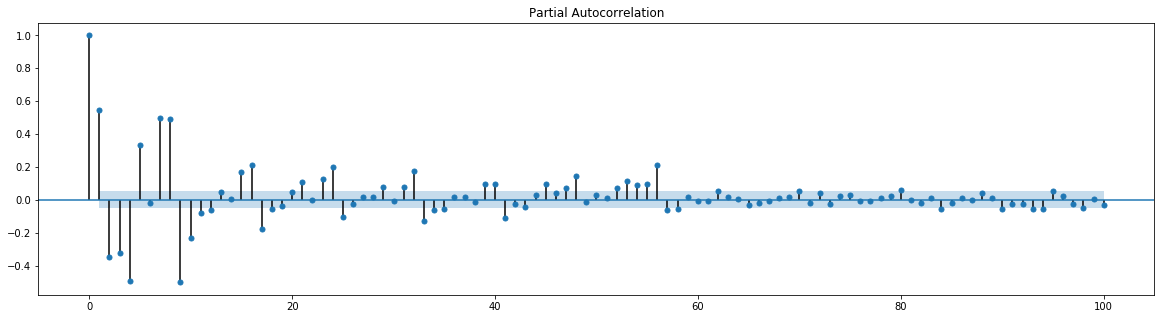

In [143]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_pacf(Series, lags=100, ax= ax)
sg.plot_pacf(df_jfk['nCabs'], lags=100, ax= ax)
plt.show()

In [144]:
# fit model
model = ARIMA(df_jfk['nCabs'], order=(8,1,4))
model_fit_cab = model.fit(disp=0)
print(model_fit_cab.summary())

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.nCabs   No. Observations:                 1446
Model:                 ARIMA(8, 1, 4)   Log Likelihood               -9560.456
Method:                       css-mle   S.D. of innovations            179.169
Date:                Tue, 18 Jun 2019   AIC                          19148.912
Time:                        17:17:47   BIC                          19222.783
Sample:                             1   HQIC                         19176.482
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0433      2.162     -0.020      0.984      -4.280       4.194
ar.L1.D.nCabs    -0.3817      0.052     -7.306      0.000      -0.484      -0.279
ar.L2.D.nCabs    -0.4797      0.042    -

In [145]:
results_cab = pd.concat([df_jfk['nCabs'],model_fit_cab.resid], axis = 1)
results_cab.dropna(inplace =True)
r2_score(results_cab['nCabs'], results_cab['nCabs'] - results_cab[0])  


/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


0.842833143912249

(array([  2.,   0.,   3.,   1.,   1.,   5.,  11.,   8.,  23.,  43.,  71.,
        111., 178., 217., 192., 187., 133., 101.,  65.,  32.,  25.,  15.,
          6.,   8.,   1.,   2.,   1.,   1.,   2.,   1.]),
 array([-814.10288422, -757.46343609, -700.82398796, -644.18453983,
        -587.5450917 , -530.90564356, -474.26619543, -417.6267473 ,
        -360.98729917, -304.34785104, -247.70840291, -191.06895478,
        -134.42950664,  -77.79005851,  -21.15061038,   35.48883775,
          92.12828588,  148.76773401,  205.40718214,  262.04663027,
         318.68607841,  375.32552654,  431.96497467,  488.6044228 ,
         545.24387093,  601.88331906,  658.52276719,  715.16221533,
         771.80166346,  828.44111159,  885.08055972]),
 <a list of 30 Patch objects>)

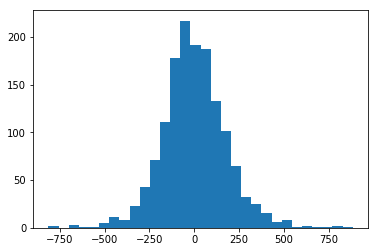

In [146]:
plt.hist(model_fit_cab.resid, bins = 30)

Text(0.5, 0, 'Residual')

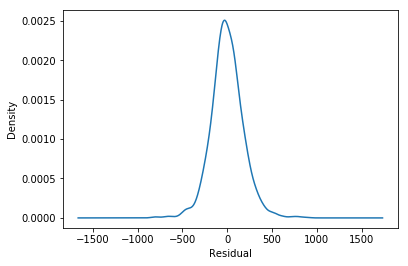

In [147]:
pd.Series(model_fit_cab.resid).plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

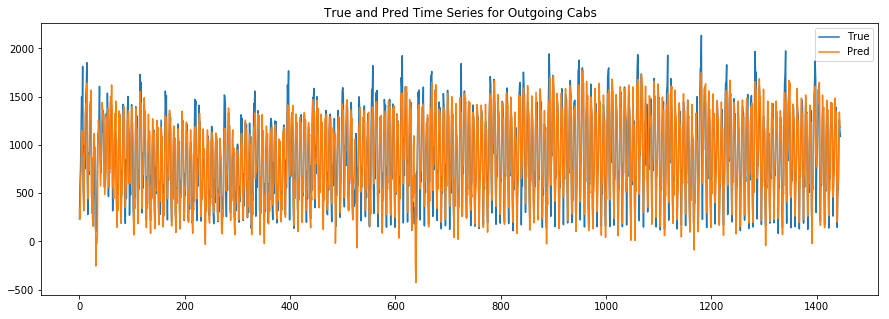

In [148]:
plt.subplots(figsize=(15,5))
plt.plot(np.arange(0,len(results_cab['nCabs']),1),results_cab['nCabs'], '-', label ='True')
plt.plot(np.arange(0,len(results_cab['nCabs']),1),results_cab['nCabs'] - results_cab[0], '-', label ='Pred')
plt.title("True and Pred Time Series for Outgoing Cabs")
plt.legend()

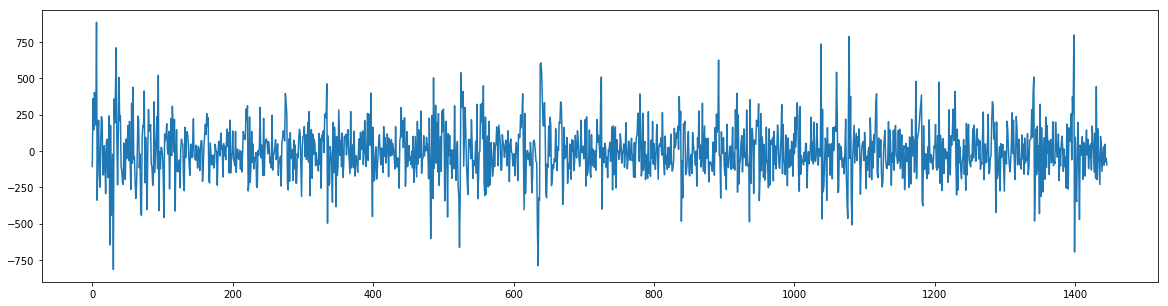

In [149]:
plt.subplots(figsize=(20,5))
plt.plot(np.arange(0,len(model_fit_cab.resid),1),model_fit_cab.resid)

### JFK Time Series

In [150]:
# check for stationarity
# result = adfuller(Series)
result = adfuller(df_jfk['nFlights'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.111962
p-value: 0.000013
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


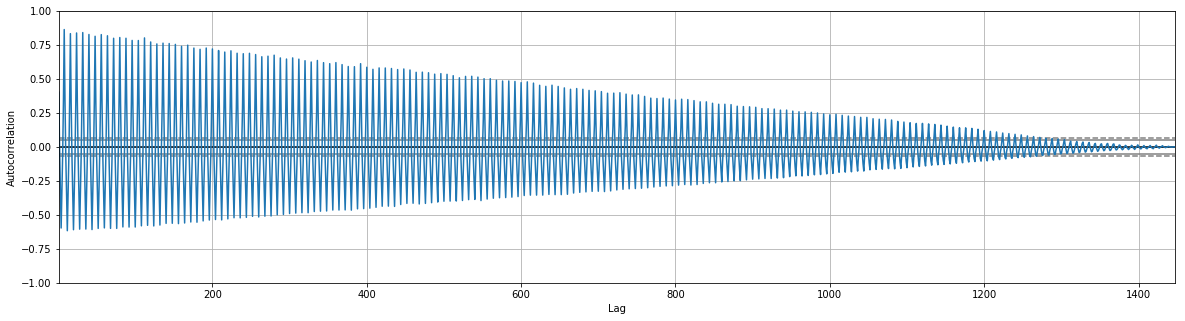

In [151]:
# plot autocorrelation in the data
plt.figure(figsize=(20, 5))
# ax = autocorrelation_plot(Series)
ax = autocorrelation_plot(df_jfk['nFlights'])


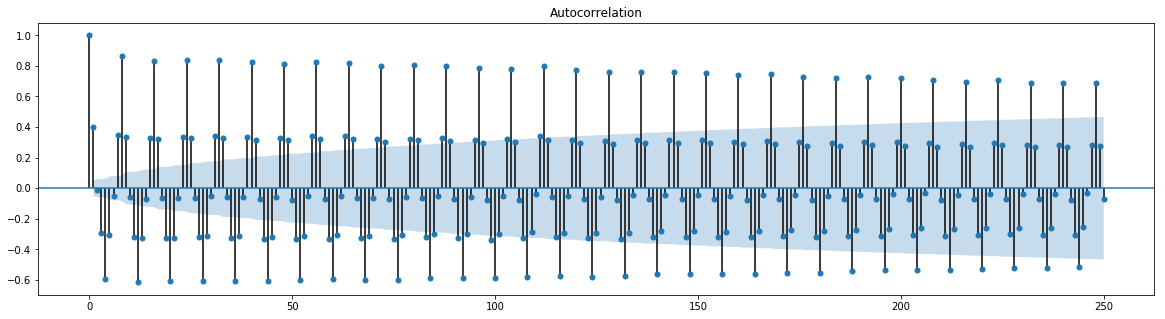

In [152]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_acf(Series, ax=ax, lags=250)
sg.plot_acf(df_jfk['nFlights'], ax=ax, lags=250)
plt.show()

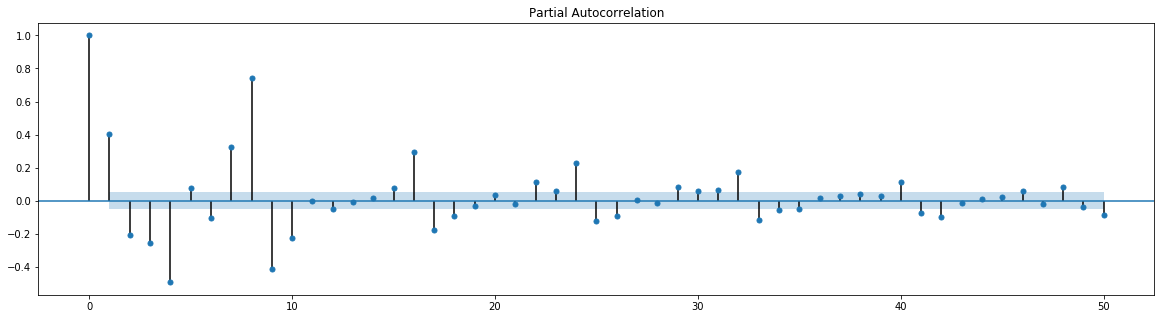

In [153]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_pacf(Series, lags=100, ax= ax)
sg.plot_pacf(df_jfk['nFlights'], lags=50, ax= ax)
plt.show()

In [154]:
# fit model
model = ARIMA(df_jfk['nFlights'], order=(8,1,4))
model_fit_flight = model.fit(disp=0)
print(model_fit_flight.summary())

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.nFlights   No. Observations:                 1446
Model:                 ARIMA(8, 1, 4)   Log Likelihood               -5204.548
Method:                       css-mle   S.D. of innovations              8.814
Date:                Tue, 18 Jun 2019   AIC                          10437.096
Time:                        17:18:05   BIC                          10510.968
Sample:                             1   HQIC                         10464.666
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0018      0.071      0.025      0.980      -0.137       0.141
ar.L1.D.nFlights    -0.4359      0.072     -6.060      0.000      -0.577      -0.295
ar.L2.D.nFlights    -0.5001 

In [155]:
results_flight = pd.concat([df_jfk['nFlights'],model_fit_flight.resid], axis = 1)
results_flight.dropna(inplace =True)
r2_score(results_flight['nFlights'], results_flight['nFlights'] - results_flight[0])  


/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


0.8099973728262486

(array([  2.,   0.,   0.,   2.,   3.,   2.,   1.,   4.,   7.,   7.,  14.,
         20.,  37.,  77., 133., 209., 207., 184., 182., 130.,  94.,  50.,
         33.,  20.,   8.,   5.,   6.,   3.,   3.,   3.]),
 array([-47.17361262, -44.41464342, -41.65567422, -38.89670501,
        -36.13773581, -33.37876661, -30.61979741, -27.86082821,
        -25.10185901, -22.3428898 , -19.5839206 , -16.8249514 ,
        -14.0659822 , -11.307013  ,  -8.54804379,  -5.78907459,
         -3.03010539,  -0.27113619,   2.48783301,   5.24680221,
          8.00577142,  10.76474062,  13.52370982,  16.28267902,
         19.04164822,  21.80061742,  24.55958663,  27.31855583,
         30.07752503,  32.83649423,  35.59546343]),
 <a list of 30 Patch objects>)

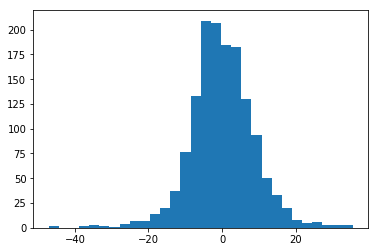

In [156]:
plt.hist(model_fit_flight.resid, bins = 30)

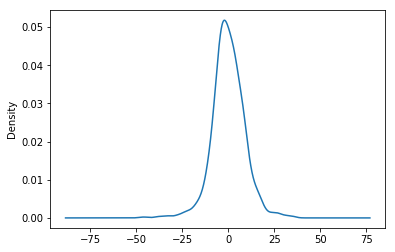

In [157]:
pd.Series(model_fit_flight.resid).plot(kind='kde', ax=plt.gca())

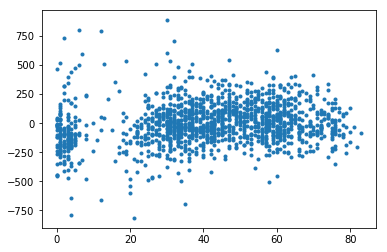

In [158]:
plt.plot(results_flight['nFlights'], results_cab[0], '.')

In [159]:
np.corrcoef(results_flight['nFlights'], results_cab[0])

array([[1.        , 0.18495062],
       [0.18495062, 1.        ]])

In [160]:
np.corrcoef(results_flight['nFlights'], results_cab['nCabs'] - results_cab[0])

array([[1.        , 0.46759392],
       [0.46759392, 1.        ]])

## Linear Model

In [161]:
df_linear = pd.DataFrame(results_cab)
df_linear['arPred'] = df_linear['nCabs'] - df_linear[0]
df_linear = pd.concat([df_linear['arPred'], df_jfk.iloc[1:,:]], axis = 1)


### Model 1: Without intercept

In [162]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+arPred-1', data = df_linear).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 2.292e+04
Date:                Tue, 18 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:18:09   Log-Likelihood:                -9512.1
No. Observations:                1446   AIC:                         1.903e+04
Df Residuals:                    1444   BIC:                         1.904e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nFlights       2.3898      0.224     10.692      0.0

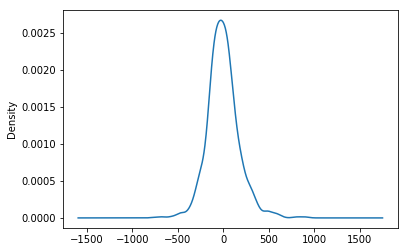

In [163]:
df_linear['combPred'] = lm.predict()
df_linear['resid'] = df_linear['nCabs'] - df_linear['combPred']
df_linear['resid'].plot(kind='kde')

### Model 2: With Intercept

In [164]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+arPred', data = df_linear).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     4251.
Date:                Tue, 18 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:18:09   Log-Likelihood:                -9510.4
No. Observations:                1446   AIC:                         1.903e+04
Df Residuals:                    1443   BIC:                         1.904e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.6368     11.764     -1.839      0.0

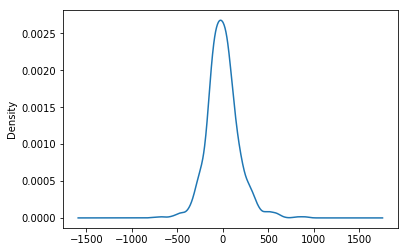

In [165]:
df_linear['combPred'] = lm.predict()
df_linear['resid'] = df_linear['nCabs'] - df_linear['combPred']
df_linear['resid'].plot(kind='kde')

### Model 3: With all Features

In [166]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+arPred+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+\
Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8', data = df_linear).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     852.5
Date:                Tue, 18 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:18:09   Log-Likelihood:                -9245.5
No. Observations:                1446   AIC:                         1.852e+04
Df Residuals:                    1430   BIC:                         1.861e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    121.5179     19.817      6.132      0.0

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


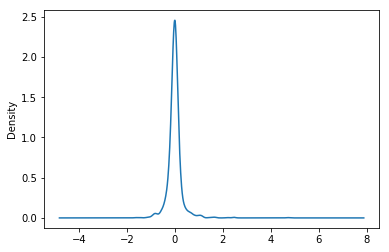

In [169]:
df_linear['combPred'] = lm.predict()
df_linear['resid'] = np.log(df_linear['nCabs']) - np.log(df_linear['combPred'])
df_linear['resid'].plot(kind='kde')

## OUTLIER DETECTION

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Convergence in 4 iterations


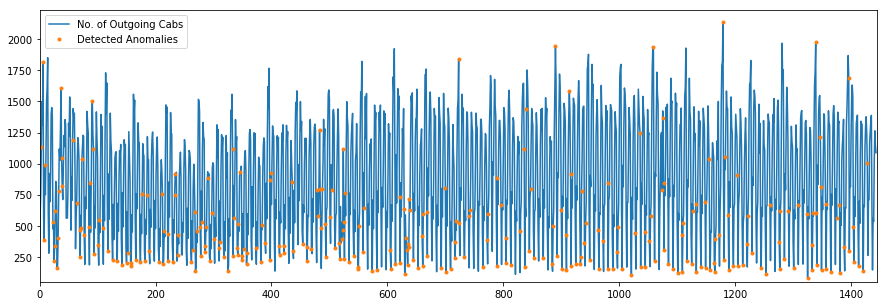

In [176]:
df_linear.dropna(inplace = True)
anomaly = anomalyDetection(df_linear['resid'], ncomp=1)
df_linear['Outlier'] = anomaly
plotAnomalies(df_linear, value='nCabs', outlier='Outlier')